### venv location:
activate the following: `~/cryptic-nn/src/fine-tuning/esmc-venv/bin/activate`

In [1]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptoshow-analysis/src/utils')
import finetuning_utils
from finetuning_utils import FinetunedEsmModel
import eval_utils
from eval_utils import CryptoBenchClassifier

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_PATH = f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model.pt'


In [3]:
SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False) #, map_location=torch.device('cpu'))

# scPDB-enhanced model
Run scPDB-enhanced model on LIGYSIS (version WITH ions).

In [4]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-enhanced-scPDB'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

predicted_binding_sites = {}
ranks = {}
predicted_binding_sites_without_smoothing = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)

    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
        eps=4,
        min_samples=2,
        method='dbscan'
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_predicted_binding_sites_without_smoothing = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        this_predicted_binding_sites_without_smoothing.append((cluster_residue_indices, 'finetuned model without smoothing'))
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, 'finetuned model with smoothing'))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0], reverse=True)]
    predicted_binding_sites[protein_id] = this_predicted_binding_sites
    predicted_binding_sites_without_smoothing[protein_id] = this_predicted_binding_sites_without_smoothing
    
if not PRECALCULATED:
    import numpy as np
    for protein_id in prediction_scores.keys():
        np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

    import pickle
    for protein_id in sequences.keys():
        filename = protein_id.replace('_','')
        with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
            pickle.dump(predicted_binding_sites[protein_id], f)


0.7198488811392038 (0.2945364719558268)
Eval method | DCC < 12 | DCC < 4
N+0: 0.5935774484161581 (0.16361522813135718)
N+2: 0.6480674222609707 (0.22784074396977622)
Conf matrix format: 
[[TN  FP] 
[FN  TP]]

clustering & smoothing:
 [[708426  45440]
 [ 35017  43188]]
clustering only:
 [[709117  44749]
 [ 36874  41331]]
MCC:
clustering & smoothing: 0.4653601389675854
clustering only: 0.4495162759541603


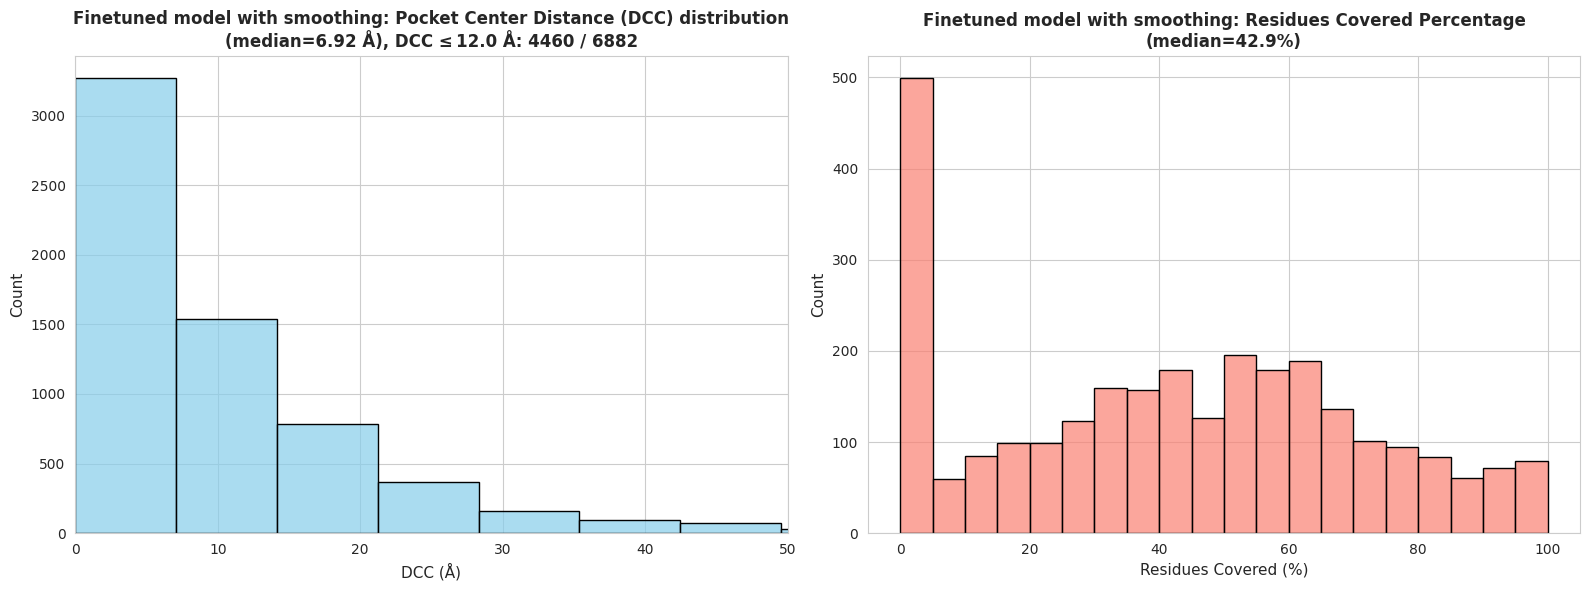

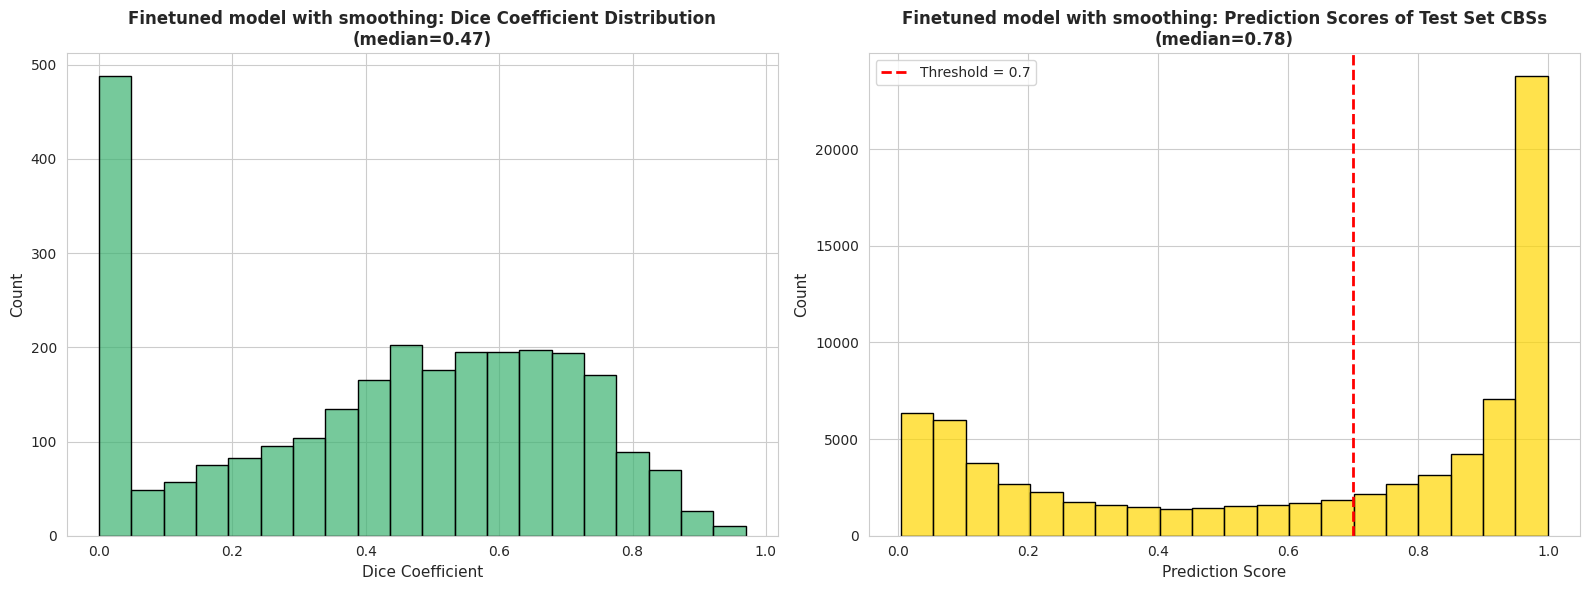

In [65]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

## Confusion matrix and MCC calculation 
from sklearn import metrics

actual = []
predicted_with_smoothing = []
predicted_without_smoothing = []

for protein_id in binding_residues.keys():
    this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in binding_residues[protein_id]:
        binding_site = [int(i.split('_')[1]) for i in binding_site]
        this_actual[binding_site] = 1
    
    this_predicted_with_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites[protein_id]:
        this_predicted_with_smoothing[binding_site] = 1
    
    this_predicted_without_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites_without_smoothing[protein_id]:
        this_predicted_without_smoothing[binding_site] = 1
    
    predicted_with_smoothing.append(this_predicted_with_smoothing)
    predicted_without_smoothing.append(this_predicted_without_smoothing)
    actual.append(this_actual)

labels = np.concatenate(actual)
predictions_with_smoothing = np.concatenate(predicted_with_smoothing)
predictions_without_smoothing = np.concatenate(predicted_without_smoothing)


print('Conf matrix format: \n[[TN  FP] \n[FN  TP]]\n')
print('clustering & smoothing:\n', metrics.confusion_matrix(labels, predictions_with_smoothing))
print('clustering only:\n', metrics.confusion_matrix(labels, predictions_without_smoothing))

print('MCC:')
print('clustering & smoothing:', metrics.matthews_corrcoef(labels, predictions_with_smoothing))
print('clustering only:', metrics.matthews_corrcoef(labels, predictions_without_smoothing))

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)

## load & merge predictions
Because there is this mess with PDB numbering vs. auth numbering, we need to translate the chain ids from PDB to auth.

In [ ]:
import pickle

with open('/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/LIGYSIS_sites_DEF_TRANS.pkl', 'rb') as file:
    df = pickle.load(file)

auth_to_label_chain_mapping = {}
for pdb_id, auth_chain_id, label_chain_id in zip(df['pdb_id'], df['auth_asym_id'], df['struct_asym_id']):
    auth_to_label_chain_mapping[(pdb_id, auth_chain_id)] = label_chain_id

# load p2rank predictions and format the pockets in the same way as our model's predictions
with open('/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB/p2rank_predictions_reformated.pkl', 'rb') as f:
    p2rank_predicted_pockets = pickle.load(f)
    p2rank_predicted_pockets = {protein_id: [(np.array([int(residue[1:]) for residue in pocket]), method) for (pocket, method) in pockets] for protein_id, pockets in p2rank_predicted_pockets[0].items()}

# map p2rank chain ids from auth to label
# p2rank_predicted_pockets = {f'{protein_id[:4]}{auth_to_label_chain_mapping[(protein_id[:4], protein_id[4:])]}': pockets for protein_id, pockets in p2rank_predicted_pockets.items() }

#predicted_binding_sites
merged_predictions = {}
p2rank_predicted_structures_count = 0
for protein_id in sequences.keys():
    protein_id_without_dash = protein_id.replace('_', '')
    merged_predictions[protein_id] = []
    # add finetuned model predictions
    for binding_sites in predicted_binding_sites[protein_id_without_dash]:
        merged_predictions[protein_id].append(binding_sites)
    # add p2rank predictions
    if protein_id_without_dash in p2rank_predicted_pockets:
        p2rank_predicted_structures_count += 1
        for binding_sites in p2rank_predicted_pockets[protein_id_without_dash]:
            merged_predictions[protein_id].append(binding_sites)

assert p2rank_predicted_structures_count == 2579, f"Number of structures with p2rank predictions is {p2rank_predicted_structures_count}, but should be 2579. (see src/E-regular-binding-site-predictor/evaluation/pocket-level-evaluation-p2rank.ipynb for details)"

0.35222319093286836 0.7580645161290323


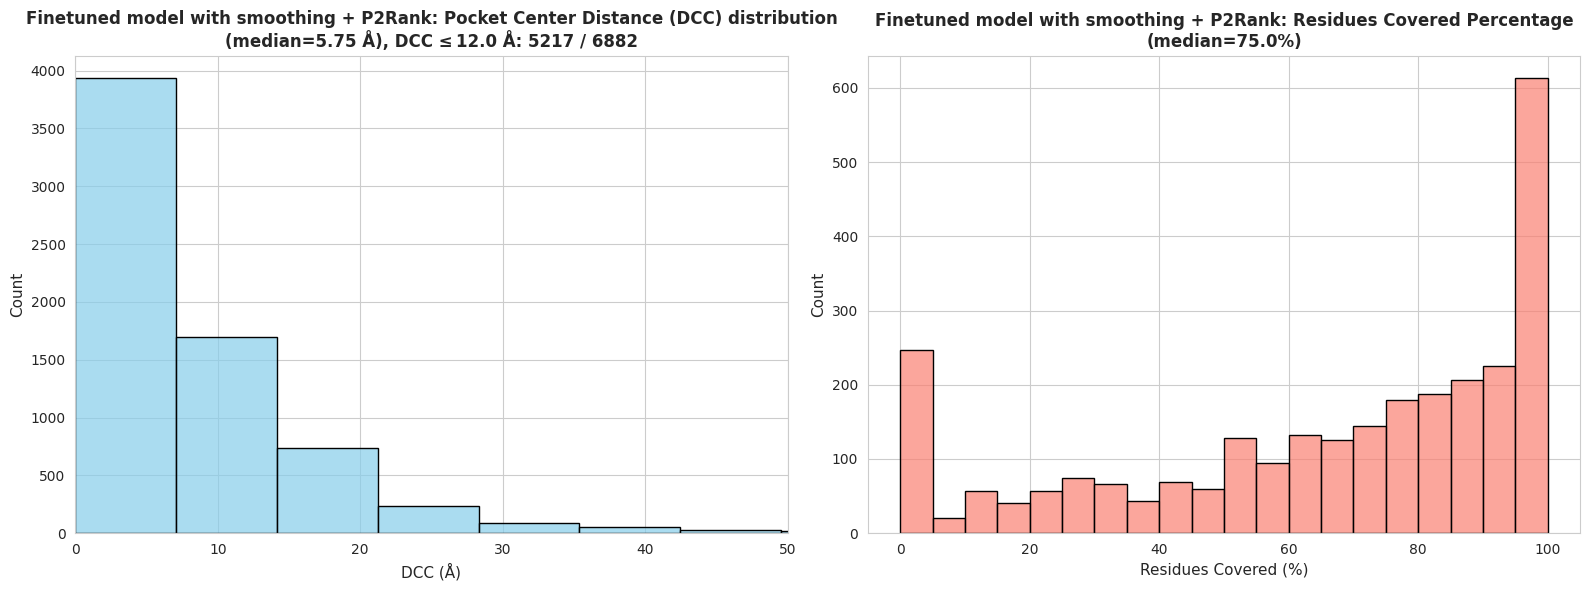

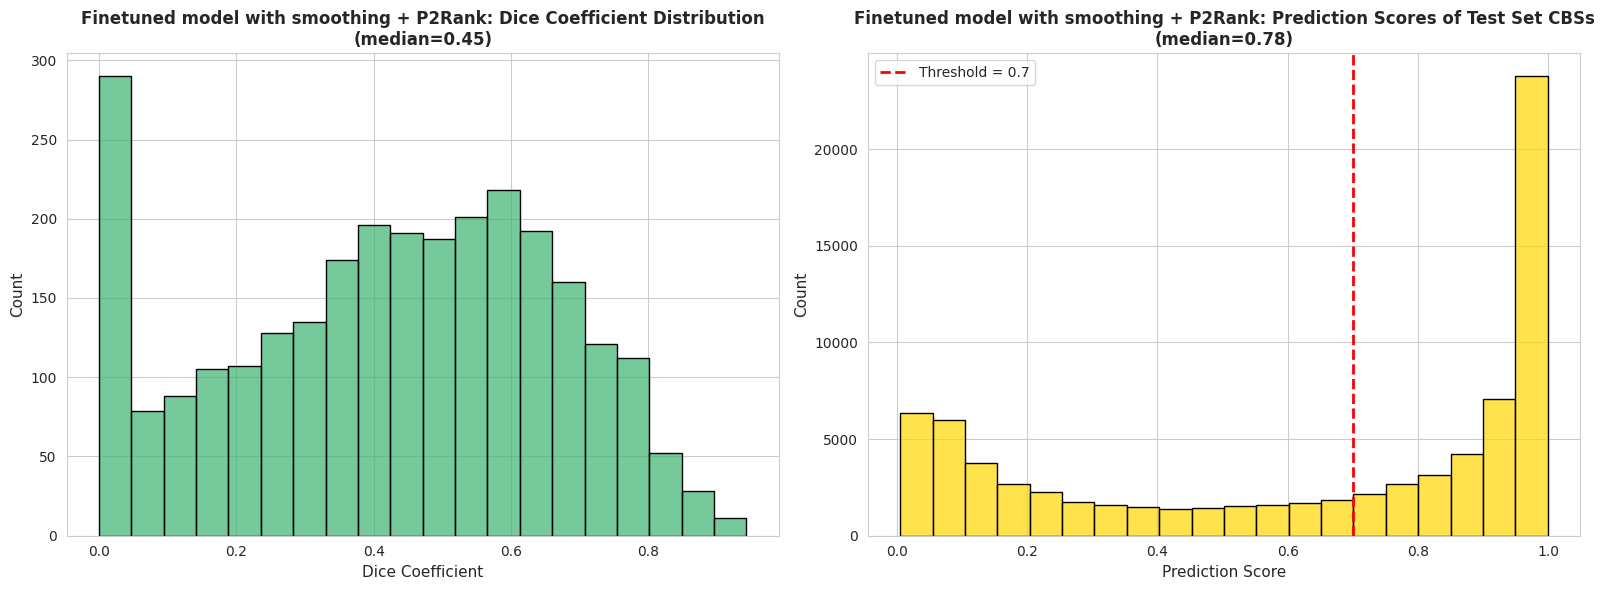

In [ ]:
# TODO: Missing confusion matrix and MCC calculation for merged predictions!

VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing + P2Rank'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, merged_predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 4) / number_of_pockets, np.sum(np.array(DCCs) < 12) / number_of_pockets)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)
# 0.8: 0.16216216216216217 0.4398430688753269
# 0.5: 0.22246439988375472 0.6287416448706771
# P2rank + finetuning with smoothing: 0.35222319093286836 0.7580645161290323
# P2rank + finetuning without smoothing: 0.3188026736413833 0.7621331008427783

## Residue-level metrics for merged predictions


In [ ]:
from sklearn import metrics

actual_labels = []
predicted_labels = []

for protein_id in sequences.keys():
    actual_labels_indices = [np.array([int(residue.split('_')[1]) for residue in pocket]) for pocket in binding_residues[protein_id]]
    this_actual_labels = np.zeros(len(sequences[protein_id]))
    for pocket_indices in actual_labels_indices:
        this_actual_labels[pocket_indices] = 1

    this_predicted_labels = np.zeros(len(sequences[protein_id]))
    for pocket_indices, method in merged_predictions[protein_id]:
        this_predicted_labels[pocket_indices] = 1
    actual_labels.append(this_actual_labels)
    predicted_labels.append(this_predicted_labels)

actual_labels = np.concatenate(actual_labels)
predicted_labels = np.concatenate(predicted_labels)

mcc = metrics.matthews_corrcoef(actual_labels, predicted_labels)
f1 = metrics.f1_score(actual_labels, predicted_labels, average='weighted')
binary_f1 = metrics.f1_score(actual_labels, predicted_labels)
precision, recall, thresholds2 = metrics.precision_recall_curve(actual_labels, predicted_labels)
auprc = metrics.auc(recall, precision)
print(f"MCC: {mcc:.4f}, F1: {f1:.4f}, binary F1: {binary_f1:.4f}; Predicted {sum(predicted_labels)} vs. Actual {sum(actual_labels)}")


MCC: 0.3869, F1: 0.8625, binary F1: 0.4375; Predicted 158784.0 vs. Actual 78205.0


# LIGYSIS_NI
Run model trained on non-ehnanced scPDB dataset on the LIGYSIS_NI subset (WITHOUT ions).

In [66]:
MODEL_PATH = f'/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/old/model.pt'
PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-NI'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-NI-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-NI'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_NI_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

if not PRECALCULATED:
    model = torch.load(MODEL_PATH, weights_only=False)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

predicted_binding_sites = {}
predicted_binding_sites_without_smoothing = {}
prediction_scores = {}

for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
        method='dbscan',
        min_samples=2,
        eps=4
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_predicted_binding_sites_without_smoothing = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        this_predicted_binding_sites_without_smoothing.append((cluster_residue_indices, 'finetuned model without smoothing'))
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        
        if embeddings.shape[0] == 0:
            this_predicted_binding_sites.append((cluster_residue_indices, 'finetuned model with smoothing'))
            this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))

            continue

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)

        # TODO: This is weird, fix later
        if indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD].shape[0] == 0:
            this_predicted_binding_sites.append((cluster_residue_indices, 'finetuned model with smoothing'))
            this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
            continue
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, 'finetuned model with smoothing'))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites_tmp = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0], reverse=True)]
    assert len(this_predicted_binding_sites_tmp) == len(this_predicted_binding_sites), f"Sorting error, {len(this_predicted_binding_sites)} != {len(this_predicted_binding_sites_tmp)}."
    predicted_binding_sites[protein_id] = this_predicted_binding_sites_tmp
    predicted_binding_sites_without_smoothing[protein_id] = this_predicted_binding_sites_without_smoothing
    
if not PRECALCULATED:
    import numpy as np
    for protein_id in prediction_scores.keys():
        np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

    import pickle

    for protein_id in sequences.keys():
        filename = protein_id.replace('_','')
        with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
            pickle.dump(predicted_binding_sites[protein_id], f)


0.5993000874890638 (0.24606299212598426)
Eval method | DCC < 12 | DCC < 4
N+0: 0.5183727034120735 (0.13823272090988625)
N+2: 0.5492125984251969 (0.20166229221347332)
Conf matrix format: 
[[TN  FP] 
[FN  TP]]

clustering & smoothing:
 [[651392  36664]
 [ 30463  38181]]
clustering only:
 [[653939  34117]
 [ 33234  35410]]
MCC:
clustering & smoothing: 0.4838317612205339
clustering only: 0.4635925619492601


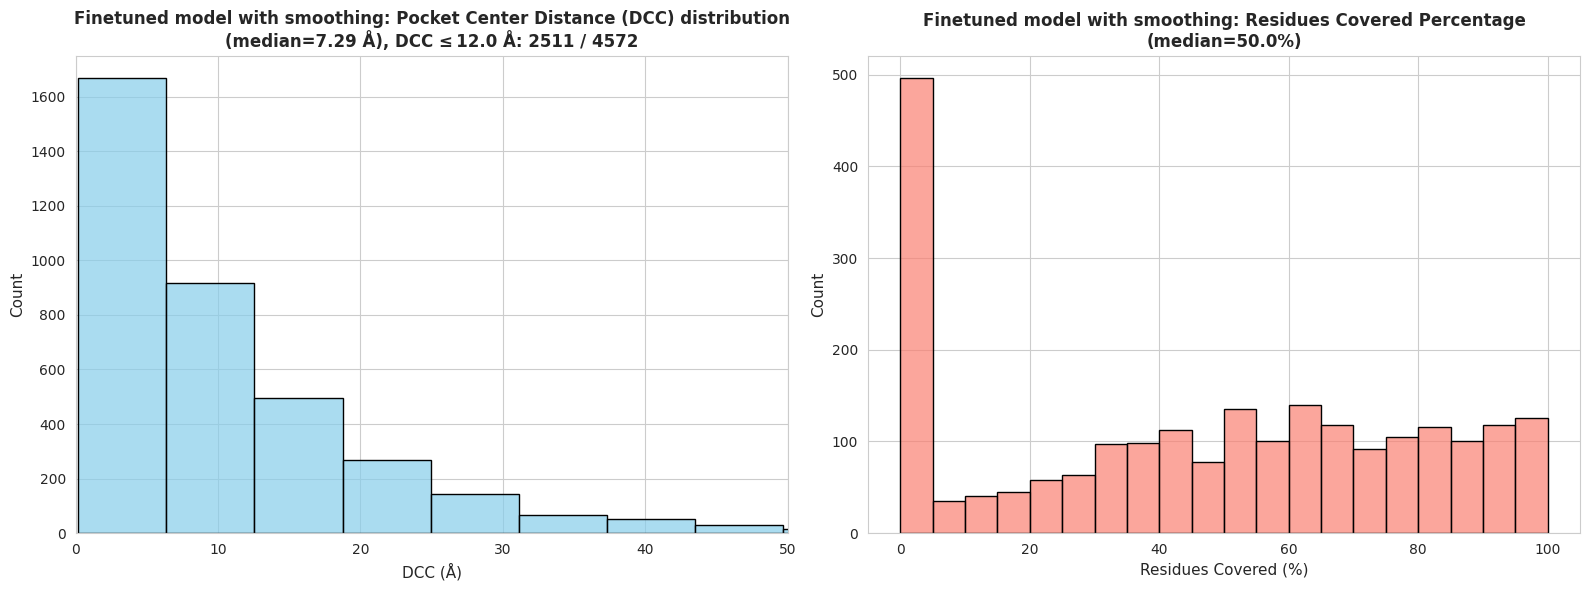

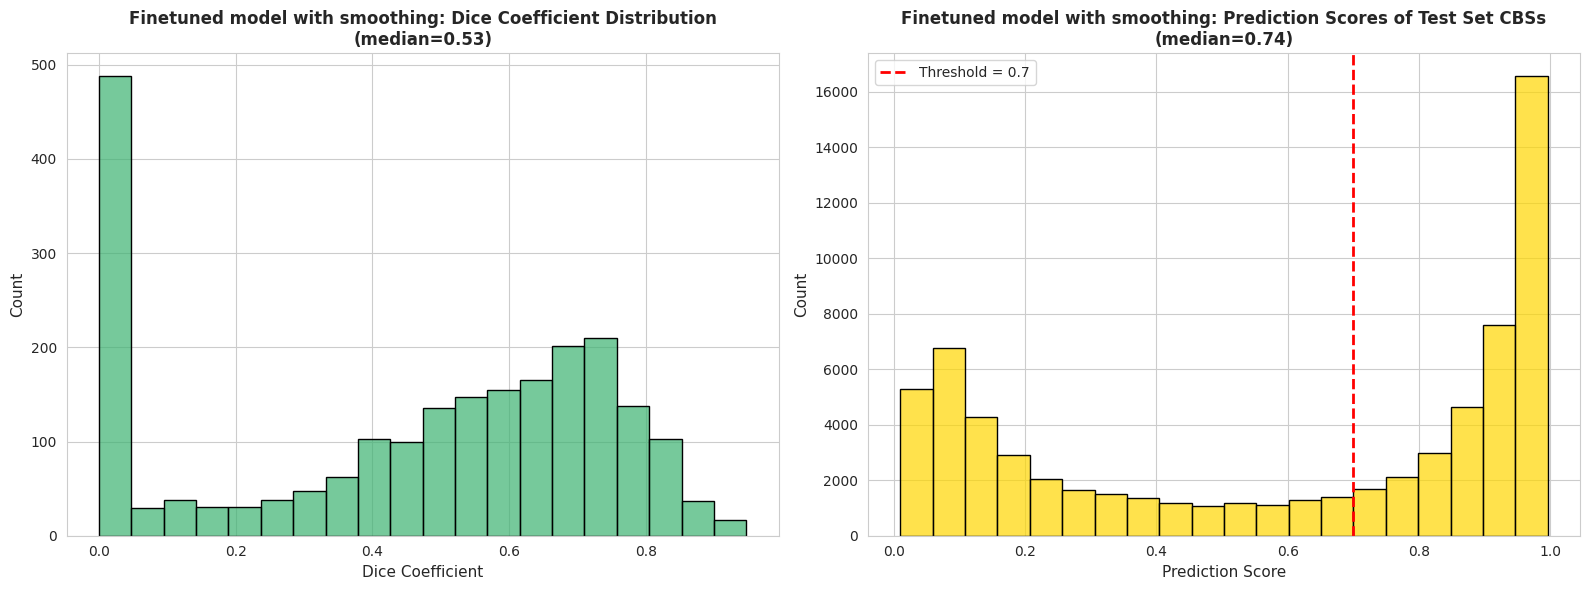

In [67]:
VERBOSE_OUTPUT = False
MODEL = 'Finetuned model with smoothing'
DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

## Confusion matrix and MCC calculation 
from sklearn import metrics

actual = []
predicted_with_smoothing = []
predicted_without_smoothing = []

for protein_id in binding_residues.keys():
    this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in binding_residues[protein_id]:
        binding_site = [int(i.split('_')[1]) for i in binding_site]
        this_actual[binding_site] = 1
    
    this_predicted_with_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites[protein_id]:
        this_predicted_with_smoothing[binding_site] = 1
    
    this_predicted_without_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites_without_smoothing[protein_id]:
        this_predicted_without_smoothing[binding_site] = 1
    
    predicted_with_smoothing.append(this_predicted_with_smoothing)
    predicted_without_smoothing.append(this_predicted_without_smoothing)
    actual.append(this_actual)

labels = np.concatenate(actual)
predictions_with_smoothing = np.concatenate(predicted_with_smoothing)
predictions_without_smoothing = np.concatenate(predicted_without_smoothing)


print('Conf matrix format: \n[[TN  FP] \n[FN  TP]]\n')
print('clustering & smoothing:\n', metrics.confusion_matrix(labels, predictions_with_smoothing))
print('clustering only:\n', metrics.confusion_matrix(labels, predictions_without_smoothing))

print('MCC:')
print('clustering & smoothing:', metrics.matthews_corrcoef(labels, predictions_with_smoothing))
print('clustering only:', metrics.matthews_corrcoef(labels, predictions_without_smoothing))

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)

## run the pipeline
this is clustering agglomerative clustering (with PCAed embeddings and estimation of active clusters using GMM) + smoothing 


In [4]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

PRECALCULATED = False
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
FINETUNED_EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-enhanced-scPDB'
PRECALCULATED_EMBEDDINGS_DIR = '/home/skrhakv/esm2/embeddings/ligysis'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

if not PRECALCULATED:
    model = torch.load(MODEL_PATH, weights_only=False)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    print(f'Processing {protein_id}...')
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{FINETUNED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        method='pca+gmm+agglomerative',
        postprocess=True,
        embeddings_path=f'{PRECALCULATED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    )

    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        predicted_binding_sites[protein_id].append((enhanced_residue_indices, 'finetuned model with smoothing'))

# import pickle
# PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/B-evaluate-cryptoshow/predictions'

# for protein_id in sequences.keys():
#     filename = protein_id.replace('_','')
#     with open(f'{PREDICTIONS_PATH}/PCA,GMM,AgglomerativeClust,thenSmoothing-finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
#         pickle.dump(predicted_binding_sites[protein_id], f)
# 

Processing 1a52_A...
Processing 1a9w_E...
Processing 1aii_A...
Processing 1au1_A...
Processing 1aue_B...
Processing 1b1c_A...
Processing 1b50_B...
Processing 1b55_B...
Processing 1b6c_F...
Processing 1b9o_A...
Processing 1bbo_A...
Processing 1bci_A...
Processing 1bf9_A...
Processing 1bhi_A...
Processing 1bld_A...
Processing 1blx_A...
Processing 1bmo_A...
Processing 1bnl_A...
Processing 1boy_A...
Processing 1bp5_A...
Processing 1buv_M...
Processing 1byg_A...
Processing 1bzs_A...
Processing 1c07_A...
Processing 1c4z_A...
Processing 1c9y_A...
Processing 1cb6_A...
Processing 1cjy_B...
Processing 1cm8_A...
Processing 1cr8_A...
Processing 1cws_A...
Processing 1cx8_C...
Processing 1cza_N...
Processing 1czv_A...
Processing 1d1s_A...
Processing 1d4u_A...
Processing 1d5g_A...
Processing 1drf_A...
Processing 1ds6_A...
Processing 1dsz_A...
Processing 1dtw_B...
Processing 1dxt_D...
Processing 1e0o_D...
Processing 1e17_A...
Processing 1e9t_A...
Processing 1eh2_A...
Processing 1ek6_A...
Processing 1e

0.552019761697181 (0.2176692821854112)


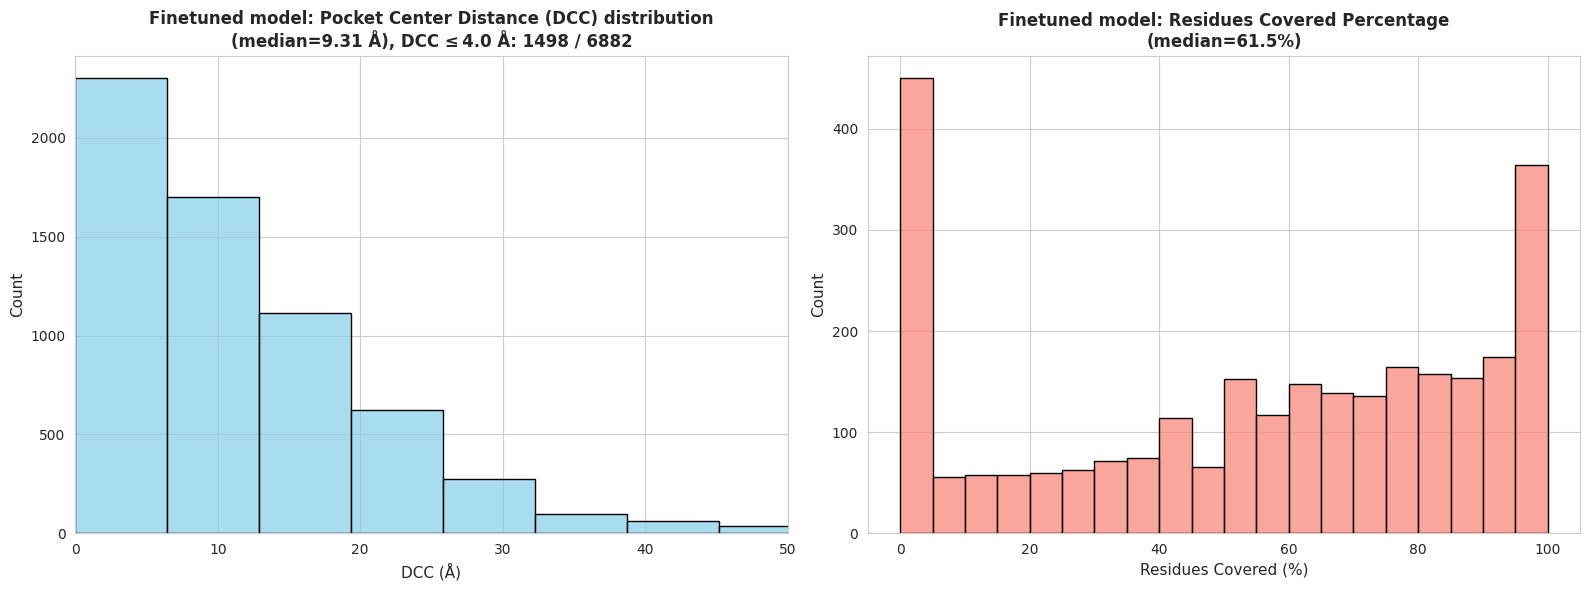

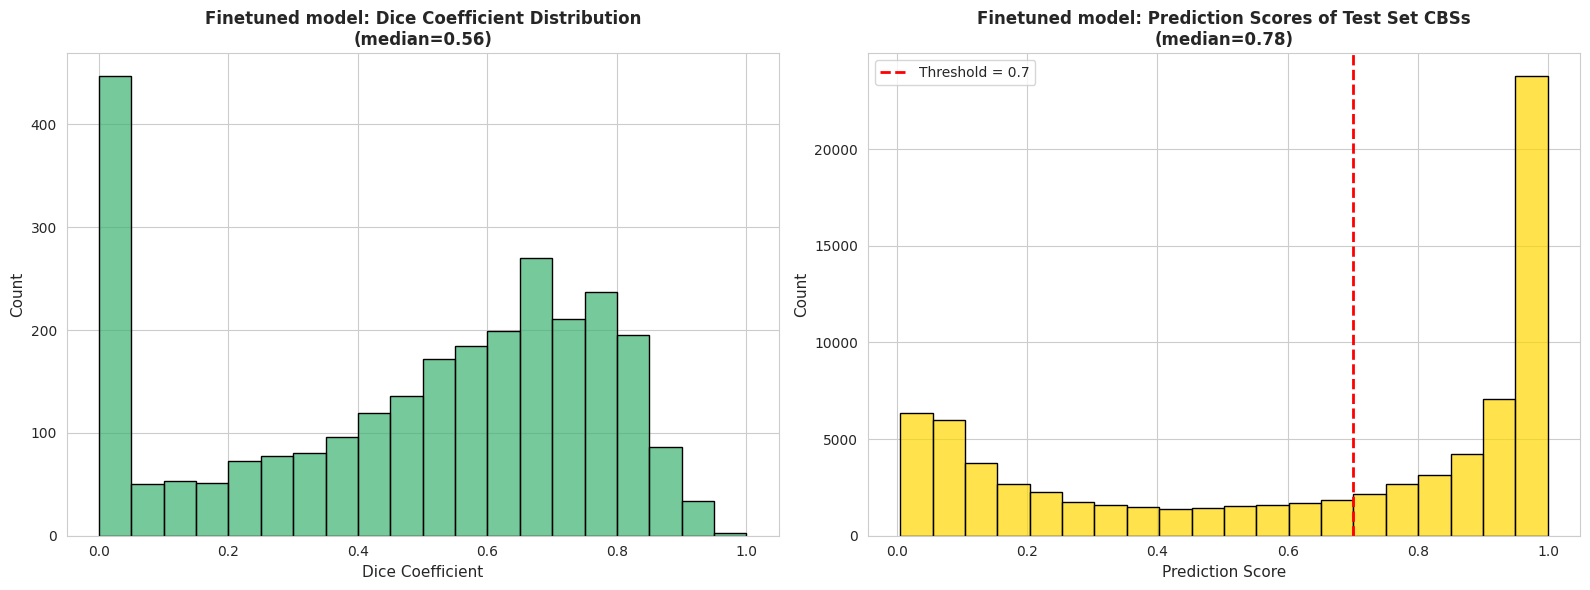

In [ ]:
MODEL = 'Finetuned model'
VERBOSE_OUTPUT = False

print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)


In [27]:
from sklearn.mixture import BayesianGaussianMixture

def remap_clusters(labels, coords):
    from scipy.spatial.distance import cdist
    from scipy.sparse.csgraph import connected_components

    centers = []
    for label in np.unique(labels):
        cluster_residues = np.where(labels == label)[0]
        centers.append(np.mean(coords[cluster_residues], axis=0))

    # 2. Define your merging threshold (in Angstroms)
    # 12-15 Angstroms is usually a good size for a binding pocket radius
    MERGE_THRESHOLD = 15.0 

    # 3. Calculate distance between all cluster centers
    # specific shape: (n_clusters, n_clusters)
    distances = cdist(centers, centers)

    # 4. Create an adjacency matrix (True if close, False if far)
    # This creates a "graph" where clusters are nodes and closeness is an edge
    adjacency_matrix = distances < MERGE_THRESHOLD

    # 5. Find connected components (groups of clusters to merge)
    # n_merged: total number of new super-clusters
    # new_mapping: array where index is old label, value is new label
    n_merged, new_mapping = connected_components(adjacency_matrix, directed=False)

    # 6. Apply the new mapping to your data points
    final_labels = new_mapping[labels]
    return final_labels




predicted_binding_sites = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{FINETUNED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    precalculated_embedding_path = f'{PRECALCULATED_EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)
    clusters = eval_utils.compute_clusters(
        coordinates,
        prediction,
        method='gmm',
    )

    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 
        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        predicted_binding_sites[protein_id].append((enhanced_residue_indices, 'finetuned model with smoothing'))

    if len(predicted_binding_sites[protein_id]) == 0:
        continue
    
    merged_binding_sites = np.concatenate([i for i, _ in predicted_binding_sites[protein_id]])
    embeddings = np.load(precalculated_embedding_path)

    binding_site_coords = coordinates[merged_binding_sites]
    binding_site_embeddings = embeddings[merged_binding_sites]

    from sklearn.decomposition import PCA

    pca = PCA(n_components=min(5, binding_site_embeddings.shape[0]), random_state=42)
    projections = pca.fit_transform(binding_site_embeddings)

    concatenated_features =  np.concatenate((projections, binding_site_coords), axis=1)

    bgmm = BayesianGaussianMixture(
        n_components=len(concatenated_features), 
        random_state=42,
        covariance_type='spherical',
        weight_concentration_prior=1e-15,
    )   

    bgmm.fit(concatenated_features)    

    active_clusters = sum(bgmm.weights_ > 0.01)

    from sklearn.cluster import AgglomerativeClustering
    clustering = AgglomerativeClustering(n_clusters=max(active_clusters, 1), linkage='single')

    labels = clustering.fit_predict(concatenated_features)
    labels = remap_clusters(labels, binding_site_coords)

    predicted_binding_sites[protein_id] = []
    for cluster_label in np.unique(labels):
        if cluster_label == -1:
            continue
        cluster_residue_indices = merged_binding_sites[np.where(labels == cluster_label)[0]]
        predicted_binding_sites[protein_id].append((cluster_residue_indices, 'finetuned model with smoothing and reclustering'))

# import pickle
# PREDICTIONS_PATH = 'TODO'
# 
# for protein_id in sequences.keys():
#     filename = protein_id.replace('_','')
#     with open(f'{PREDICTIONS_PATH}/GMMspherical,smoothing,PCA,GMM,AgglomerativeClust-finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
#         pickle.dump(predicted_binding_sites[protein_id], f)
# import numpy as np
# for protein_id in prediction_scores.keys():
#     np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

0.548823016564952 (0.2173786689915722)


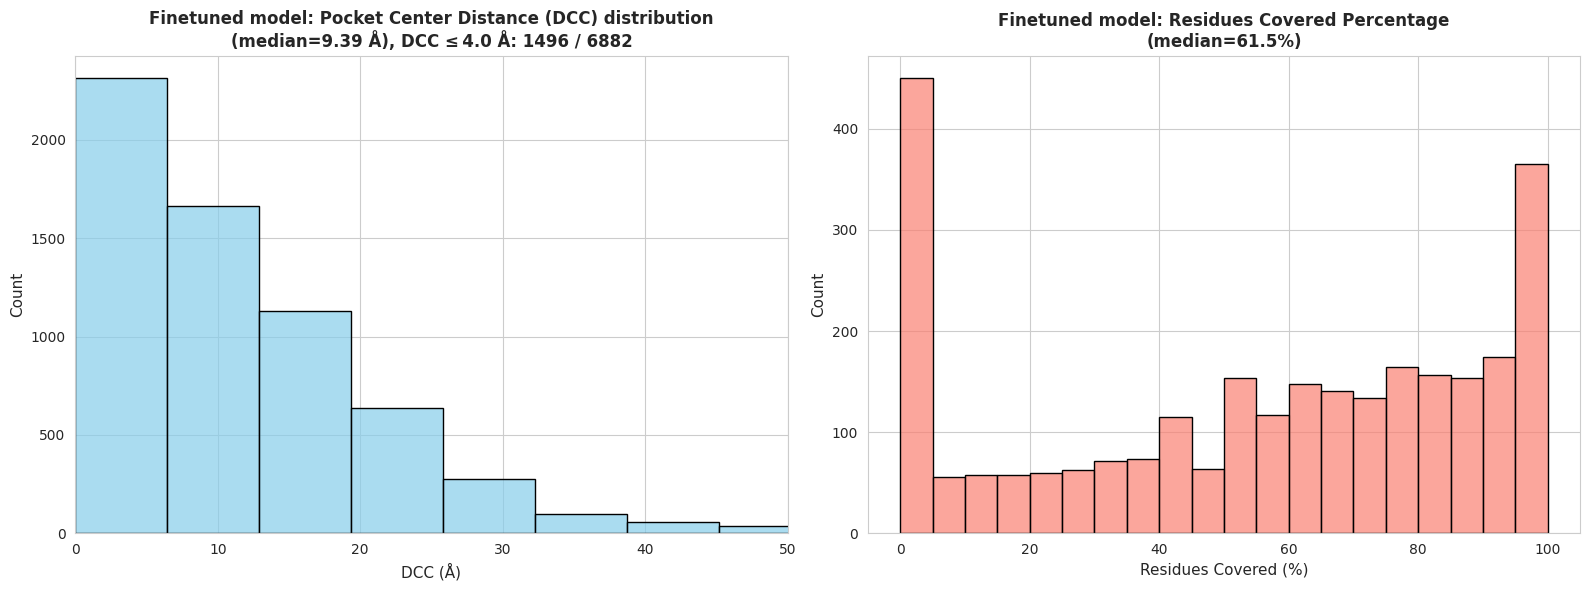

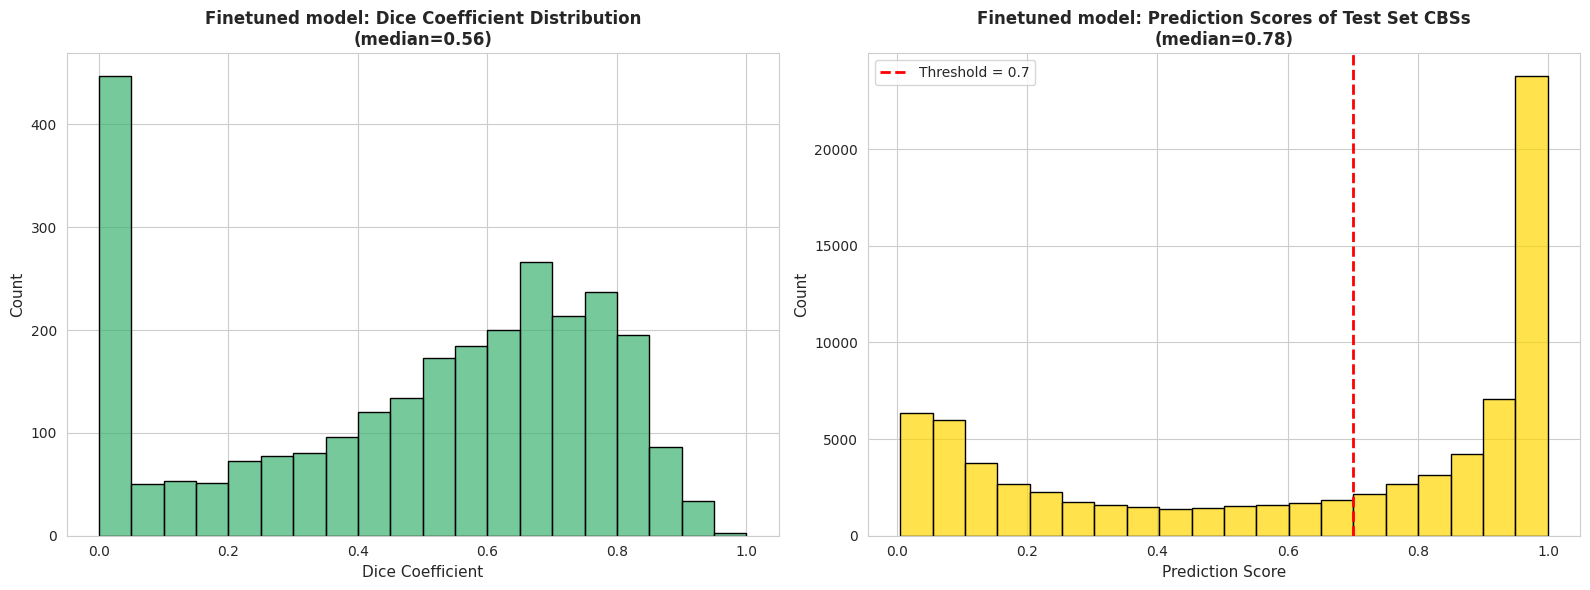

In [ ]:
MODEL = 'Finetuned model'
VERBOSE_OUTPUT = False

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')
eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL)


# MERGE_THRESHOLD = 15.0, n_components=5:  0.5598663179308341 (0.22653298459750074)
# MERGE_THRESHOLD = 18.0, n_components=5:  0.549985469340308 (0.21810520197616973)
# MERGE_THRESHOLD = 15.0, n_components=10: 0.531676838128451 (0.2067712874164487)
# MERGE_THRESHOLD = 15.0, n_components=10, bgmm.weights_ > 0.05: 0.5704736995059576 (0.23205463528044173)
# MERGE_THRESHOLD = 15.0, n_components=10, bgmm.weights_ > 0.01: 0.548823016564952 (0.2173786689915722) # This is weird, I expected better results if we split it into more components.


## Back to basics
Try simple DBscan, together with postprocessing.

In [4]:
DECISION_THRESHOLD = 0.5




def compute_clusters(
    points: list[list[float]],
    prediction_scores: list[float],
    decision_threshold: float = DECISION_THRESHOLD,
    eps=5,
    min_samples=2,
    method='dbscan',
    merge_threshold=None,
):
    from sklearn.cluster import DBSCAN
    """
    Compute clusters based on the given points and prediction scores.

    Args:
        points (list[list[float]]): A list of points, where each point is a list of 3 coordinates [x, y, z].
        prediction_scores (list[float]): A list of prediction scores corresponding to each point.
        decision_threshold (float): The threshold above which points are considered as positive.
        eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        min_samples (int): The number of samples in a neighborhood for a point to be considered

    Returns:
        np.ndarray: An array of cluster labels for each point. Points with no cluster are labeled as -1.
    """
    
    if method not in ['dbscan', 'meanshift', 'kmeans', 'gmm', 'pca+gmm+agglomerative']:
        raise ValueError(f"Unsupported clustering method: {method}. Supported methods are 'dbscan', 'meanshift', and 'kmeans'.")
    
    prediction_scores = prediction_scores.reshape(-1, 1)
    stacked = np.hstack((points, prediction_scores))  # Combine coordinates with scores

    high_score_mask = stacked[:, 3] > decision_threshold
    high_score_points = stacked[high_score_mask][:, :3]  # Extract only (x, y, z) coordinates

    # No pockets can be formed if there are not enough high score points.
    if len(high_score_points) < min_samples:
        return -1 * np.ones(len(points), dtype=int)

    if method == 'dbscan':
        clustering = DBSCAN(eps=eps, min_samples=min_samples)

    labels = clustering.fit_predict(high_score_points)
    
    if merge_threshold is not None:
        from scipy.spatial.distance import cdist
        from scipy.sparse.csgraph import connected_components

        if method == 'gmm':
            centers = clustering.means_ 
        else:
            centers = []
            for label in np.unique(labels):
                if label == -1:
                    continue
                cluster_residues = np.where(labels == label)[0]
                assert len(labels) == len(high_score_points), "Labels length must match high_score_points length"
                centers.append(np.mean(high_score_points[cluster_residues], axis=0))
        
        if len(centers) != 0:
            # Calculate distance between all cluster centers
            # shape: (n_clusters, n_clusters)
            distances = cdist(centers, centers)

            # Create an adjacency matrix (True if close, False if far)
            # This creates a "graph" where clusters are nodes and closeness is an edge
            adjacency_matrix = distances < merge_threshold

            # Find connected components (groups of clusters to merge)
            # n_merged: total number of new super-clusters
            # new_mapping: array where index is old label, value is new label
            n_merged, new_mapping = connected_components(adjacency_matrix, directed=False)

            # Apply the new mapping to your data points
            final_labels = new_mapping[labels]
            labels = final_labels

    for min_samples in []:
        if np.any(labels == -1):
            non_clustered_points_mask = labels == -1
            non_clustered_points = high_score_points[non_clustered_points_mask]
            clustering2 = DBSCAN(eps=eps, min_samples=min_samples)
            labels2 = clustering2.fit_predict(non_clustered_points)
            labels[non_clustered_points_mask] = labels2 + labels.max() + 1

    # Initialize all labels to -1
    all_labels = -1 * np.ones(len(points), dtype=int)
    # Assign cluster labels to high score points
    all_labels[high_score_mask] = labels
    labels = all_labels

    return labels



MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
EMBEDDINGS_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-enhanced-scPDB'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

predicted_binding_sites = {}
ranks = {}
predicted_binding_sites_without_smoothing = {}
prediction_scores = {}
for protein_id in sequences.keys():
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{EMBEDDINGS_DIR}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'

    if not PRECALCULATED:
        # finetuned prediction
        prediction = eval_utils.compute_prediction(
            sequence,
            embeddings_path,
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        prediction = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = prediction
    
    # cluster predicted pockets
    coordinates = np.load(coordinates_path)

    clusters = compute_clusters(
        coordinates,
        prediction,
        decision_threshold=DECISION_THRESHOLD,
        eps=6,
        min_samples=1,
        method='dbscan',
        # merge_threshold=8.0
    )

    assert coordinates.shape[0] == prediction.shape[0], "Number of coordinates must match number of prediction scores."
    # load distance matrix
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    # enhance predicted pockets using the smoothing model
    this_predicted_binding_sites = []
    this_predicted_binding_sites_without_smoothing = []
    this_ranks = []
    for cluster_label in np.unique(clusters):
        if cluster_label == -1:
            continue
        cluster_residue_indices = np.where(clusters == cluster_label)[0]
        this_predicted_binding_sites_without_smoothing.append((cluster_residue_indices, 'finetuned model without smoothing'))
        embeddings, indices = eval_utils.process_single_sequence(pdb_id, chain_id, cluster_residue_indices, embeddings_path, distance_matrix) 

        prediction = eval_utils.predict_single_sequence(embeddings, indices, smoothing_model)
        
        enhanced_residue_indices = np.concatenate((indices[prediction['predictions'] > eval_utils.SMOOTHING_DECISION_THRESHOLD], cluster_residue_indices))
        this_predicted_binding_sites.append((enhanced_residue_indices, prediction_scores[protein_id][cluster_residue_indices]))
        this_ranks.append(np.mean(prediction_scores[protein_id][cluster_residue_indices]))
    
    # sort by the rank:
    this_predicted_binding_sites = [pocket for rank, pocket in sorted(zip(this_ranks, this_predicted_binding_sites), key=lambda x: x[0], reverse=True)]
    predicted_binding_sites[protein_id] = this_predicted_binding_sites
    predicted_binding_sites_without_smoothing[protein_id] = this_predicted_binding_sites_without_smoothing
    
if not PRECALCULATED:
    import numpy as np
    for protein_id in prediction_scores.keys():
        np.save(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy', prediction_scores[protein_id])

    import pickle
    for protein_id in sequences.keys():
        filename = protein_id.replace('_','')
        with open(f'{PREDICTIONS_PATH}/finetuning-with-smoothing/{filename}.pkl', 'wb') as f:
            pickle.dump(predicted_binding_sites[protein_id], f)


In [ ]:
# import pickle
# import os
# 
# out_dir = f'{PREDICTIONS_PATH}/dbscan,eps=6,min_samples=1,finetuning-with-smoothing,with-scores'
# os.makedirs(out_dir, exist_ok=True)
# 
# for protein_id in sequences.keys():
#     filename = protein_id.replace('_','')
#     with open(f'{out_dir}/{filename}.pkl', 'wb') as f:
#         pickle.dump(predicted_binding_sites[protein_id], f)
# 

0.7496367335077012 (0.2887242080790468)
Eval method | DCC < 12 | DCC < 4
N+0: 0.5908166230746876 (0.18715489683231618)
N+2: 0.6596919500145306 (0.23205463528044173)
Conf matrix format: 
[[TN  FP] 
[FN  TP]]

clustering & smoothing:
 [[695249  58617]
 [ 28484  49721]]
clustering only:
 [[695252  58614]
 [ 28488  49717]]
MCC:
clustering & smoothing: 0.4838787002009503
clustering only: 0.48385109109405344


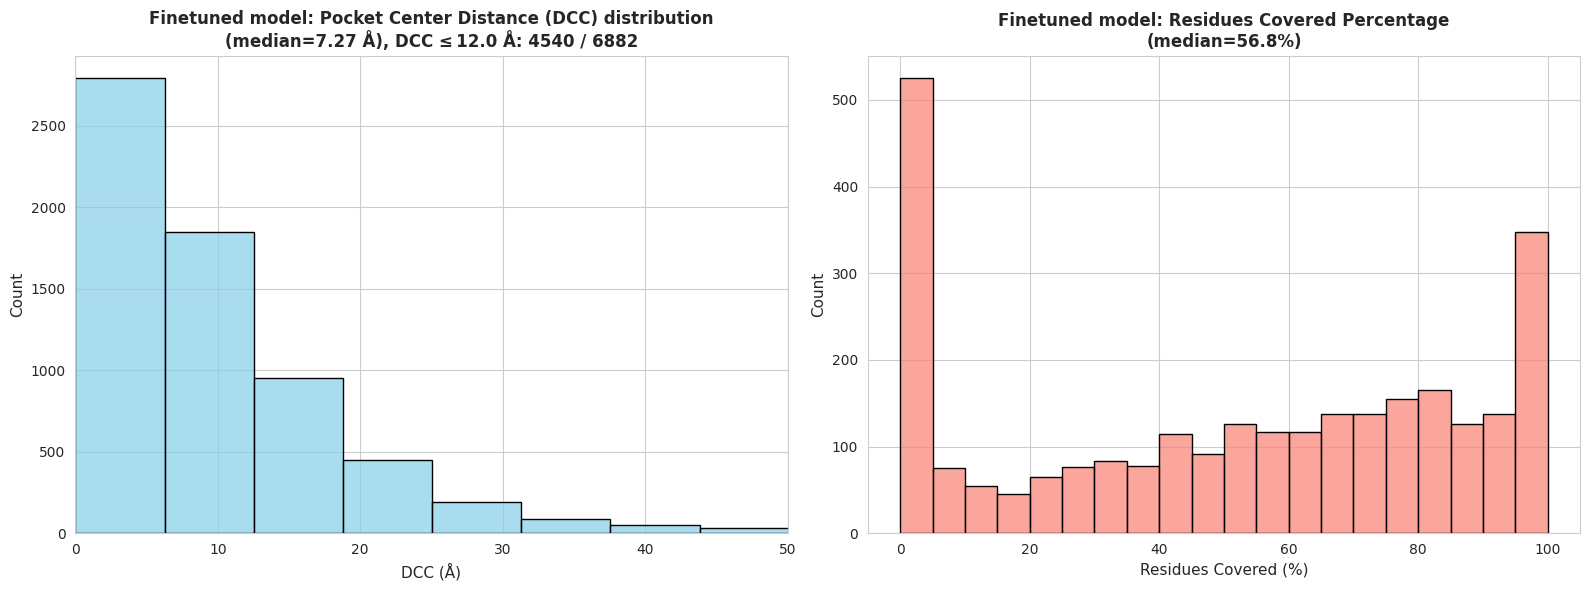

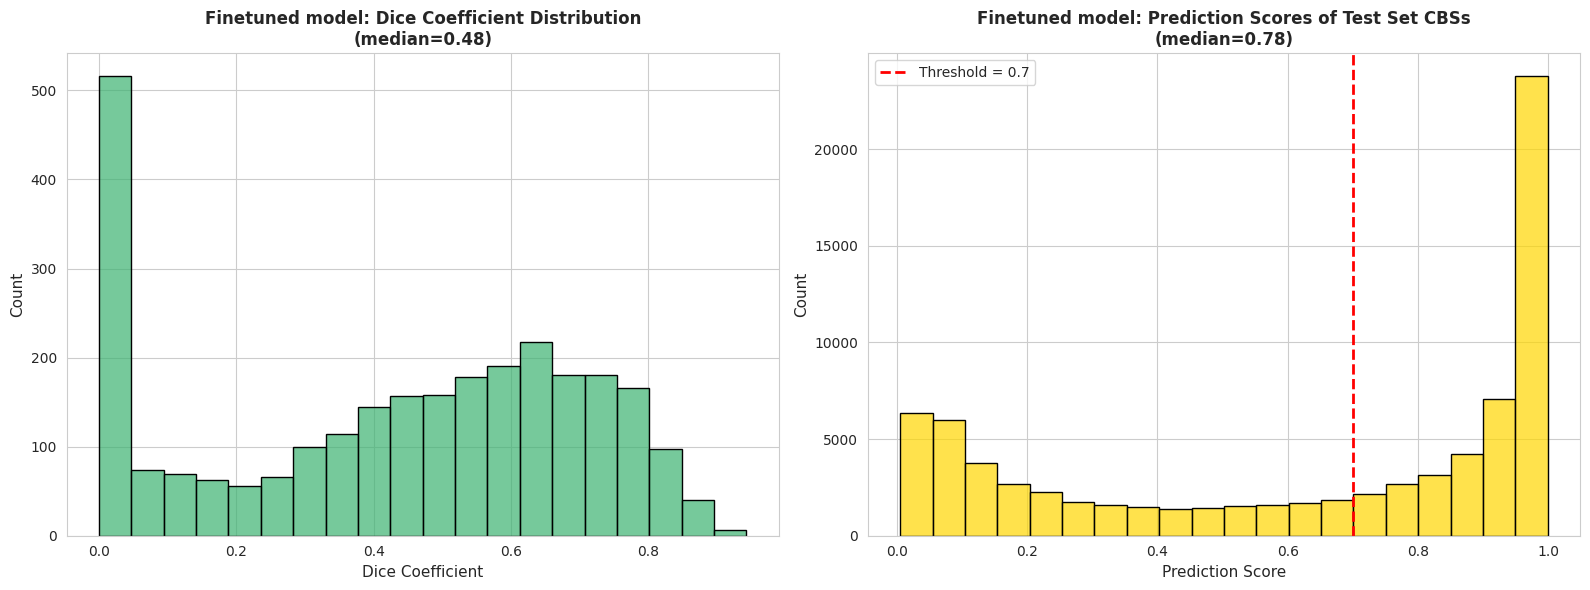

In [ ]:
MODEL = 'Finetuned model'
VERBOSE_OUTPUT = False

DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predicted_binding_sites, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')
print("Eval method | DCC < 12 | DCC < 4")
for K in [0, 2]:
    predictions = {}
    for protein_id in predicted_binding_sites.keys():
        N = len(binding_residues[protein_id])
        this_predictions = predicted_binding_sites[protein_id][:min(len(predicted_binding_sites[protein_id])-1, N + K)]
        predictions[protein_id] = this_predictions
    DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets = eval_utils.compute_pocket_level_metrics(binding_residues, predictions, prediction_scores, COORDINATES_DIR, VERBOSE_OUTPUT)
    print(f'N+{K}:', np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')

## Confusion matrix and MCC calculation 
from sklearn import metrics

actual = []
predicted_with_smoothing = []
predicted_without_smoothing = []

for protein_id in binding_residues.keys():
    this_actual = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site in binding_residues[protein_id]:
        binding_site = [int(i.split('_')[1]) for i in binding_site]
        this_actual[binding_site] = 1
    
    this_predicted_with_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites[protein_id]:
        this_predicted_with_smoothing[binding_site] = 1
    
    this_predicted_without_smoothing = np.zeros(len(sequences[protein_id]), dtype=int)
    for binding_site, _ in predicted_binding_sites_without_smoothing[protein_id]:
        this_predicted_without_smoothing[binding_site] = 1
    
    predicted_with_smoothing.append(this_predicted_with_smoothing)
    predicted_without_smoothing.append(this_predicted_without_smoothing)
    actual.append(this_actual)

labels = np.concatenate(actual)
predictions_with_smoothing = np.concatenate(predicted_with_smoothing)
predictions_without_smoothing = np.concatenate(predicted_without_smoothing)


print('Conf matrix format: \n[[TN  FP] \n[FN  TP]]\n')
print('clustering & smoothing:\n', metrics.confusion_matrix(labels, predictions_with_smoothing))
print('clustering only:\n', metrics.confusion_matrix(labels, predictions_without_smoothing))

print('MCC:')
print('clustering & smoothing:', metrics.matthews_corrcoef(labels, predictions_with_smoothing))
print('clustering only:', metrics.matthews_corrcoef(labels, predictions_without_smoothing))

eval_utils.print_plots(DCCs, coverages, dice_coefficients, binding_prediction_scores, number_of_pockets, MODEL, dcc_threshold=12.0)

# 0.513077593722755  (0.16317930834059866) merge_threshold=15.0, dbscan (eps=4)
# 0.5614646904969486 (0.1827956989247312)  merge_threshold=12.0, dbscan (eps=4)
# 0.6268526591107236 (0.21301947108398722) merge_threshold=10.0, dbscan (eps=4)
# 0.6887532693984307 (0.2813135716361523)  merge_threshold=8.0, dbscan (eps=4)
# 0.7195582679453647 (0.2946817785527463)  no merge, dbscan (eps=4)

# 0.6483580354548096 (0.22319093286835223) merge_threshold=10.0, dbscan (eps=5)


# multiple dbscan: dbscan (eps=6, min_samples=[3,1]), merge_threshold=None
# 0.7478930543446672 (0.2871258355129323)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.591252542865446 (0.18497529787852368)
# N+2: 0.6598372566114502 (0.23089218250508572)

# multiple dbscan: dbscan (eps=6, min_samples=[5,1]), merge_threshold=None merge_threshold=None
# 0.7808776518453938 (0.3222900319674513)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.6219122348154607 (0.17785527462946818)
# N+2: 0.7027027027027027 (0.25268817204301075)

# multiple dbscan: dbscan (eps=6, min_samples=[5,3,1]), merge_threshold=None merge_threshold=None
# 0.6849752978785237 (0.2646033129904098)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.5446091252542865 (0.15751235106073816)
# N+2: 0.5826794536471955 (0.1960185992444057)

# single dbscan: dbscan (eps=6, min_samples=1), merge_threshold=None
# 0.7496367335077012 (0.2887242080790468)
# Eval method | DCC < 12 | DCC < 4
# N+0: 0.5908166230746876 (0.18715489683231618)
# N+2: 0.6596919500145306 (0.23205463528044173)

# NOTE: eps>6 splits the pockets too much, leading to worse results (in the graphs below - mean=3.45).


In [7]:
def compute_coverage(y_true, y_pred):
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    intersection = y_true_set.intersection(y_pred_set)
    coverage = len(intersection) / len(y_true_set)
    return coverage

def get_counts(binding_residues, model_predictions):
    counts = []
    for protein_id in binding_residues.keys():
        y_true_pockets = binding_residues[protein_id]
        y_pred_pockets = model_predictions[protein_id]
        for y_true_pocket in y_true_pockets:
            y_true_pocket = np.array([int(residue.split('_')[1]) for residue in y_true_pocket])
            number_of_predicted_pockets = 0
            for y_pred_pocket in y_pred_pockets:
                coverage = compute_coverage(y_true=y_true_pocket, y_pred=y_pred_pocket)
                if coverage > 0:
                    number_of_predicted_pockets += 1
            if number_of_predicted_pockets != 0:
                counts.append(number_of_predicted_pockets) 

    return counts


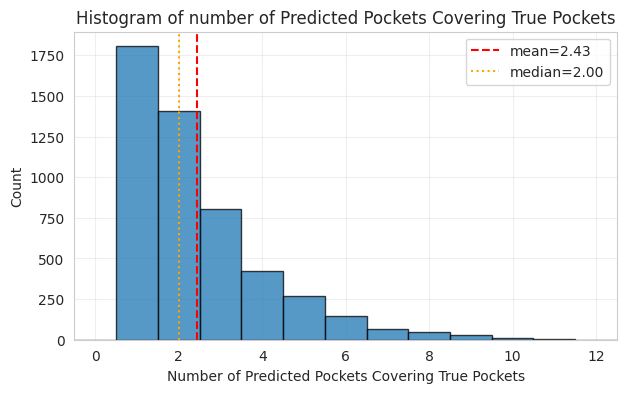

In [ ]:
# 0.7496367335077012 (0.2887242080790468) single dbscan: dbscan (eps=6, min_samples=1), merge_threshold=None
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

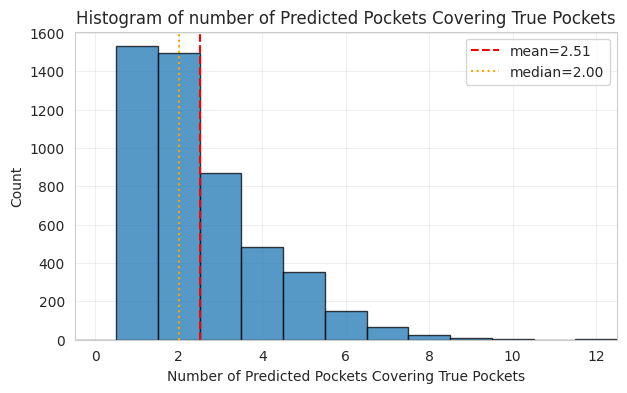

In [37]:
# multiple dbscan: dbscan (eps=6, min_samples=[5,3,1]), merge_threshold=None merge_threshold=None
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

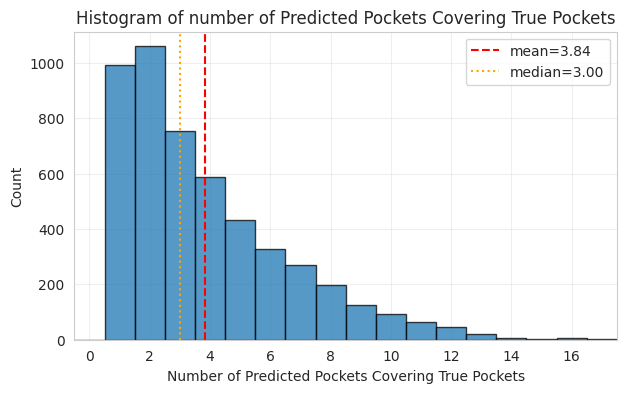

In [ ]:
# 0.7808776518453938 (0.3222900319674513) multiple dbscan: dbscan (eps=6, min_samples=[3,1]), merge_threshold=None
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

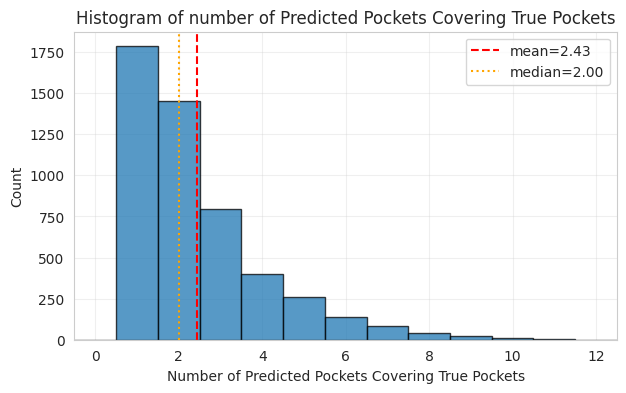

In [ ]:
# 0.7478930543446672 (0.2871258355129323) multiple dbscan: dbscan (eps=6, min_samples=[3,1]), merge_threshold=None
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

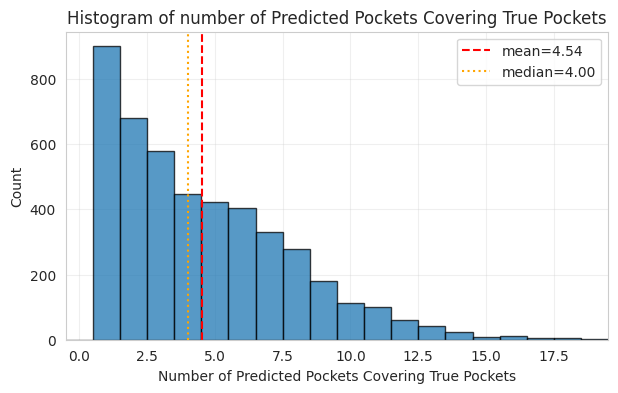

In [ ]:
# 0.7195582679453647 (0.2946817785527463)  no merge, dbscan

formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}
def compute_coverage(y_true, y_pred):
    y_true_set = set(y_true)
    y_pred_set = set(y_pred)
    intersection = y_true_set.intersection(y_pred_set)
    coverage = len(intersection) / len(y_true_set)
    return coverage

def get_counts(binding_residues, model_predictions):
    counts = []
    for protein_id in binding_residues.keys():
        y_true_pockets = binding_residues[protein_id]
        y_pred_pockets = model_predictions[protein_id]
        for y_true_pocket in y_true_pockets:
            y_true_pocket = np.array([int(residue.split('_')[1]) for residue in y_true_pocket])
            number_of_predicted_pockets = 0
            for y_pred_pocket in y_pred_pockets:
                coverage = compute_coverage(y_true=y_true_pocket, y_pred=y_pred_pocket)
                if coverage > 0:
                    number_of_predicted_pockets += 1
            if number_of_predicted_pockets != 0:
                counts.append(number_of_predicted_pockets) 

    return counts

# 0.7195582679453647 (0.2946817785527463)  no merge, dbscan


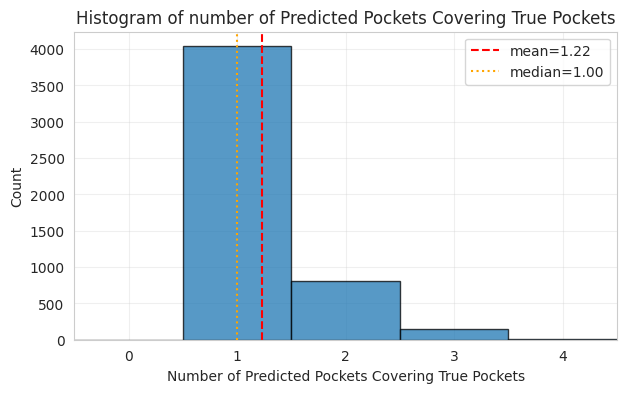

In [45]:
# 0.513077593722755  (0.16317930834059866) merge_threshold=15.0, dbscan
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

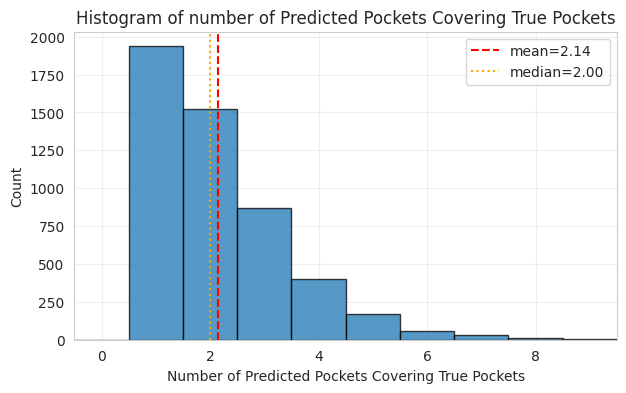

In [48]:
# 0.6268526591107236 (0.21301947108398722) merge_threshold=10.0, dbscan
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

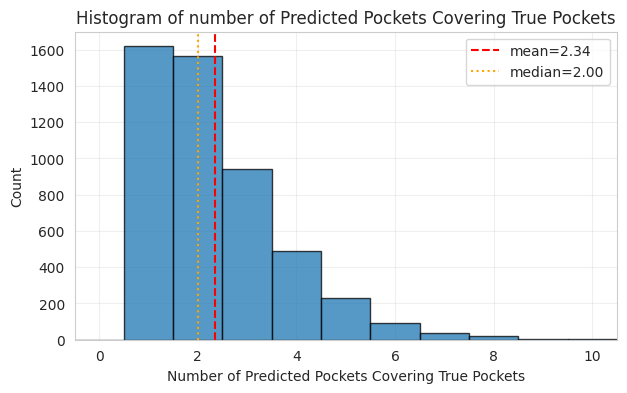

In [52]:
# 0.6483580354548096 (0.22319093286835223) merge_threshold=10.0, dbscan (eps=5)
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

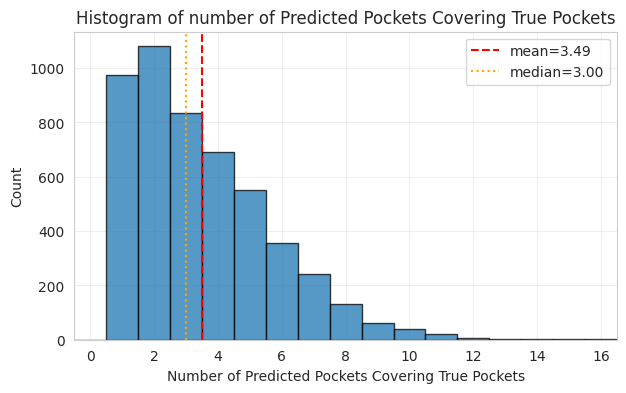

In [63]:
# 0.6887532693984307 (0.2813135716361523)  merge_threshold=8.0, dbscan (eps=4)
formatted_predicted_binding_sites = {protein_id: [pocket[0] for pocket in pockets] for protein_id, pockets in predicted_binding_sites.items()}

counts = get_counts(binding_residues, formatted_predicted_binding_sites)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 4))
# replot with bins shifted by +0.5
bins = np.arange(-0.5, max(counts) + 1.5, 1)
ax.clear()
ax.hist(counts, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(counts)
median_cov = np.median(counts)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(-0.5, max(counts) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()